In [1]:
!git clone https://github.com/trungson077/Dataset

Cloning into 'Dataset'...
remote: Enumerating objects: 12163, done.
remote: Counting objects: 100% (12163/12163), done.
remote: Compressing objects: 100% (12163/12163), done.
remote: Total 12163 (delta 0), reused 12163 (delta 0), pack-reused 0
Receiving objects: 100% (12163/12163), 156.98 MiB | 41.66 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls Dataset

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras 
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense,Lambda,ELU
from keras.layers.normalization import BatchNormalization
import cv2
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import os
import ntpath

Using TensorFlow backend.


In [5]:
datadir= 'Dataset'
columns= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center']= data['center'].apply(path_leaf)
data['left']= data['left'].apply(path_leaf)
data['right']= data['right'].apply(path_leaf)
data.head()


center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
26
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]
[  35    6    6    6   13    8   24   22   53  131   99  158 2990  137
   86  126   54   22   19    2    9    4    4    6   33]


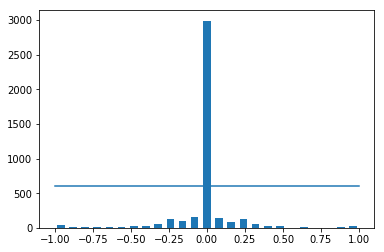

In [7]:
#visualizing data , phai balance data boi vi neu train model ra 0 het thi xe se tu di duong thang = > balance data 
num_bins = 25 # whatever values we get from steering we'll devide this entire range into 25 intervals , must a odd
samples_per_bin = 600 #threshhold 
hist, bins = np.histogram(data['steering'], num_bins) #lay so lieu cua tat ca steering data tu data frame , num_bins tra ve 2 gia tri histogram cua chinh no
center = (bins[:-1] + bins[1:])*0.5 #lam du lieu 2 khoang bang nhau
print(bins)
print(len(bins))
print(center)
print(hist)# so luong du lieu trong khoang tu -1 -> 1
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) #phan khuc du lieu , loai bo nhung thang >200
#each hz coor assigned a ver y value

total data:  4053
removed: 2390
remaining: 1663


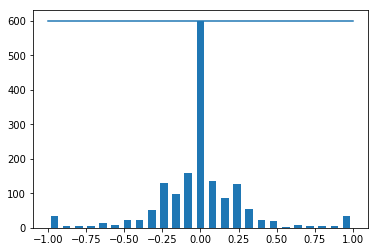

In [8]:
#balancing data (can phai can bang lai du lieu neu ko xe se co xu huong luon chay thang)
print('total data: ', len(data))
remove_list= []
for j in range(num_bins): #bat dau bang viec looping qua tung single bin
  list_= []
  for i in range(len(data['steering'])): #co lap goc lai cua bin hien tai co xu huong lap lai
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j +1]: 
      list_.append(i)  
  list_ = shuffle(list_)# tron cac bin
  list_ = list_[samples_per_bin:] #lay nhung phan tu >200
  remove_list.extend(list_)
    
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True) #inplate=true update value con lai sau khi da remove 
print('remaining:', len(data))


hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) #phan khuc du lieu , loai bo nhung thang >200



    
    

In [0]:
 #du lieu dau ra phai can doi ca ben trai va ben phai 

In [11]:

print(len(data))
print(data.iloc[3]) #show data frame thu nhat
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) #strip loai bo space trong 1 chuoi string
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(image_paths[1])
print(steerings[1])






1663
center      center_2018_07_16_17_11_44_558.jpg
left        left_2018_07_16_17_11_44_558.jpg  
right       right_2018_07_16_17_11_44_558.jpg 
steering   -0.4                               
throttle    1                                 
reverse     0                                 
speed       2.86485                           
Name: 14, dtype: object
Dataset/IMG/left_2018_07_16_17_11_44_274.jpg
0.15


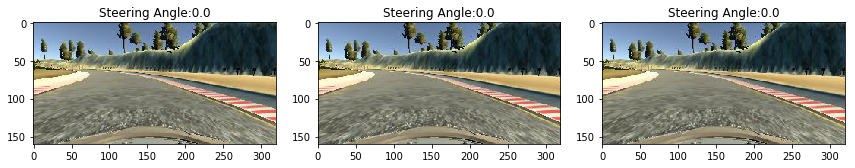

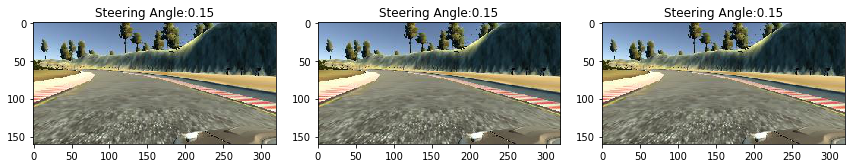

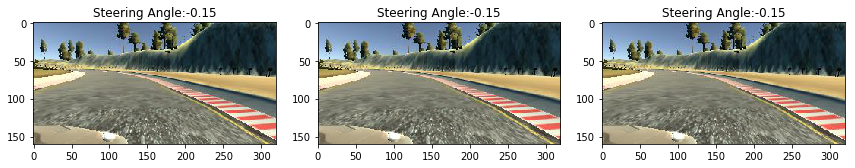

In [59]:
for i in range(len(image_paths[0:3])):
  image = image_paths[i] # chon ngau nhien 0-1000 cai anh
  steering_angle = steerings[i]

  original_image = mpimg.imread(image) #store image vao original image variable

  fig , axs = plt.subplots(1, 3, figsize=(12,4) )#1 row, 3 cols
  fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

  axs[0].imshow(original_image)
  axs[0].set_title('Steering Angle:' + str(steering_angle))

  axs[1].imshow(original_image)
  axs[1].set_title('Steering Angle:' + str(steering_angle))
  
  axs[2].imshow(original_image)
  axs[2].set_title('Steering Angle:' + str(steering_angle))

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6) #train data lay 20% tu tap du lieu , vaf valid data lay 20% tu tap train
print('Training samples: {}\nValid samples: {}'.format(len(X_train), len(X_valid)))


Training samples: 3991
Valid samples: 998


Text(0.5, 1.0, 'Validation set')

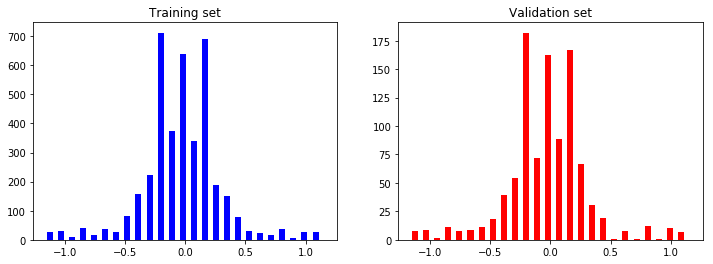

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color = 'red')
axes[1].set_title('Validation set')


In [0]:
#Genarator agumentation techniques de tao du lieu da dang hon
def zoom(image): #zooming
  zoom = iaa.Affine(scale=(1 ,1.3)) #1 la ko zoom , 1.3 la zoom tu 0- 30% random
  image = zoom.augment_image(image) #luu tru lai gia tri zoom vua roi vao image
  return image


Text(0.5, 1.0, 'Zoom Image')

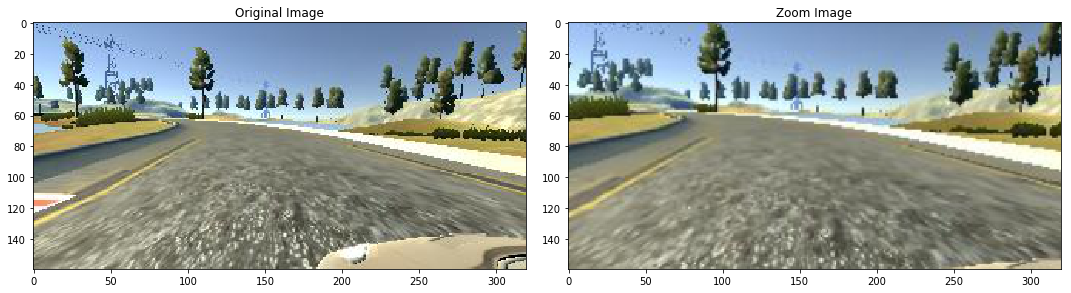

In [63]:
image = image_paths[random.randint(0, 1000)] # chon ngau nhien 0-1000 cai anh
original_image = mpimg.imread(image) #store image vao original image variable
zoomed_image = zoom(original_image) #image panning

fig , axs = plt.subplots(1, 2, figsize=(15,10) )#1 row, 2 cols
fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoom Image")


In [0]:
def pan(image): #image panning ky thuat dung de tao them su da dang cho hinh anh bang cach them % o truc ox , oy
  pan = iaa.Affine(translate_percent={ "x" : (-0.1, 0.1), "y" : (-0.1, 0.1) }) # chon ngau nhien de set truc x,y tu trong khoang 10%
  image = pan.augment_image(image)
  return image
       

Text(0.5, 1.0, 'Pan Image')

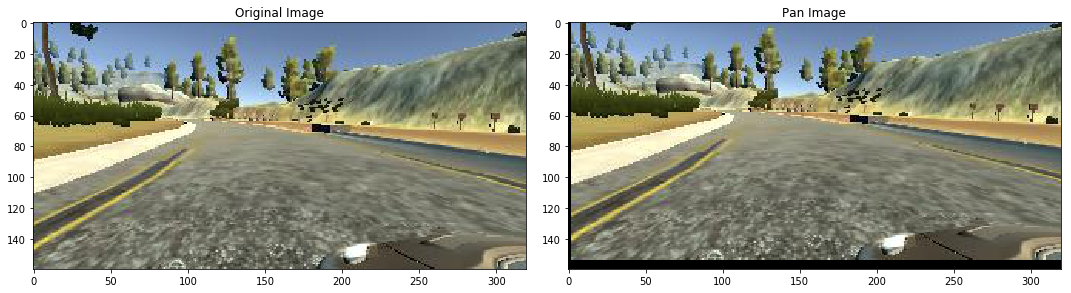

In [0]:
image = image_paths[random.randint(0, 1000)] # chon ngau nhien 0-1000 cai anh
original_image = mpimg.imread(image) #store image vao original image variable
panned_image = pan(original_image) #image panning

fig , axs = plt.subplots(1, 2, figsize=(15,10) )#1 row, 2 cols
fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Pan Image")

In [0]:
def img_random_brightness(image): #lam anh sang  hon or toi hon
  brightness = iaa.Multiply((0.2, 1.2)) #mutiplies all the cuong do sang tron anh ,  do do bat ky anh nao dc nhan vs 1 gt  <1 se tro nen toi hon, va >1 sang hon, chon random trong khoang tu 0.2-1.2
  image = brightness.augment_image(image)
  return image

    
  

Text(0.5, 1.0, 'Brightness altered Image')

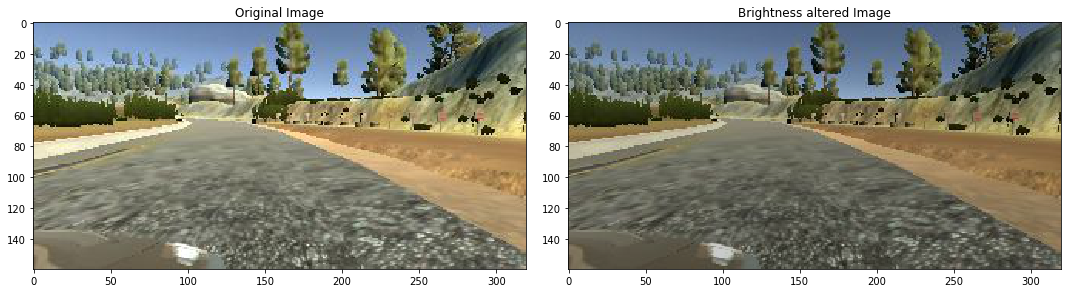

In [0]:
image = image_paths[random.randint(0, 1000)] # chon ngau nhien 0-1000 cai anh
original_image = mpimg.imread(image) #store image vao original image variable
brightness_altered_image = img_random_brightness(original_image) #image panning

fig , axs = plt.subplots(1, 2, figsize=(15,10) )#1 row, 2 cols
fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered Image")

In [0]:
#flipping technique
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)#1:horizontal flip , 0: verticle , -1: both
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image -Steering Angle:0.15')

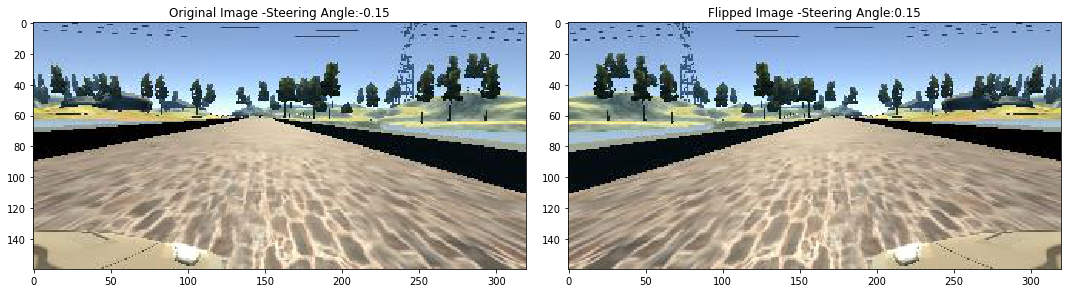

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index] # chon ngau nhien 0-1000 cai anh
steering_angle = steerings[random_index]

original_image = mpimg.imread(image) #store image vao original image variable
flipped_image , flipped_steering_angle= img_random_flip(original_image, steering_angle) #image panning

fig , axs = plt.subplots(1, 2, figsize=(15,10) )#1 row, 2 cols
fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

axs[0].imshow(original_image)
axs[0].set_title('Original Image -' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image -' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle): #func nay de tao ra du lieu random 50% cho toan bo ky thuat tang cuong o tren
  image= mpimg.imread(image)
  if np.random.rand() <0.5:
    image = pan(image)
  if np.random.rand() <0.5:
    image = zoom(image)
  if np.random.rand() <0.5:
    image = img_random_brightness(image)
  if np.random.rand() <0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle
    
  

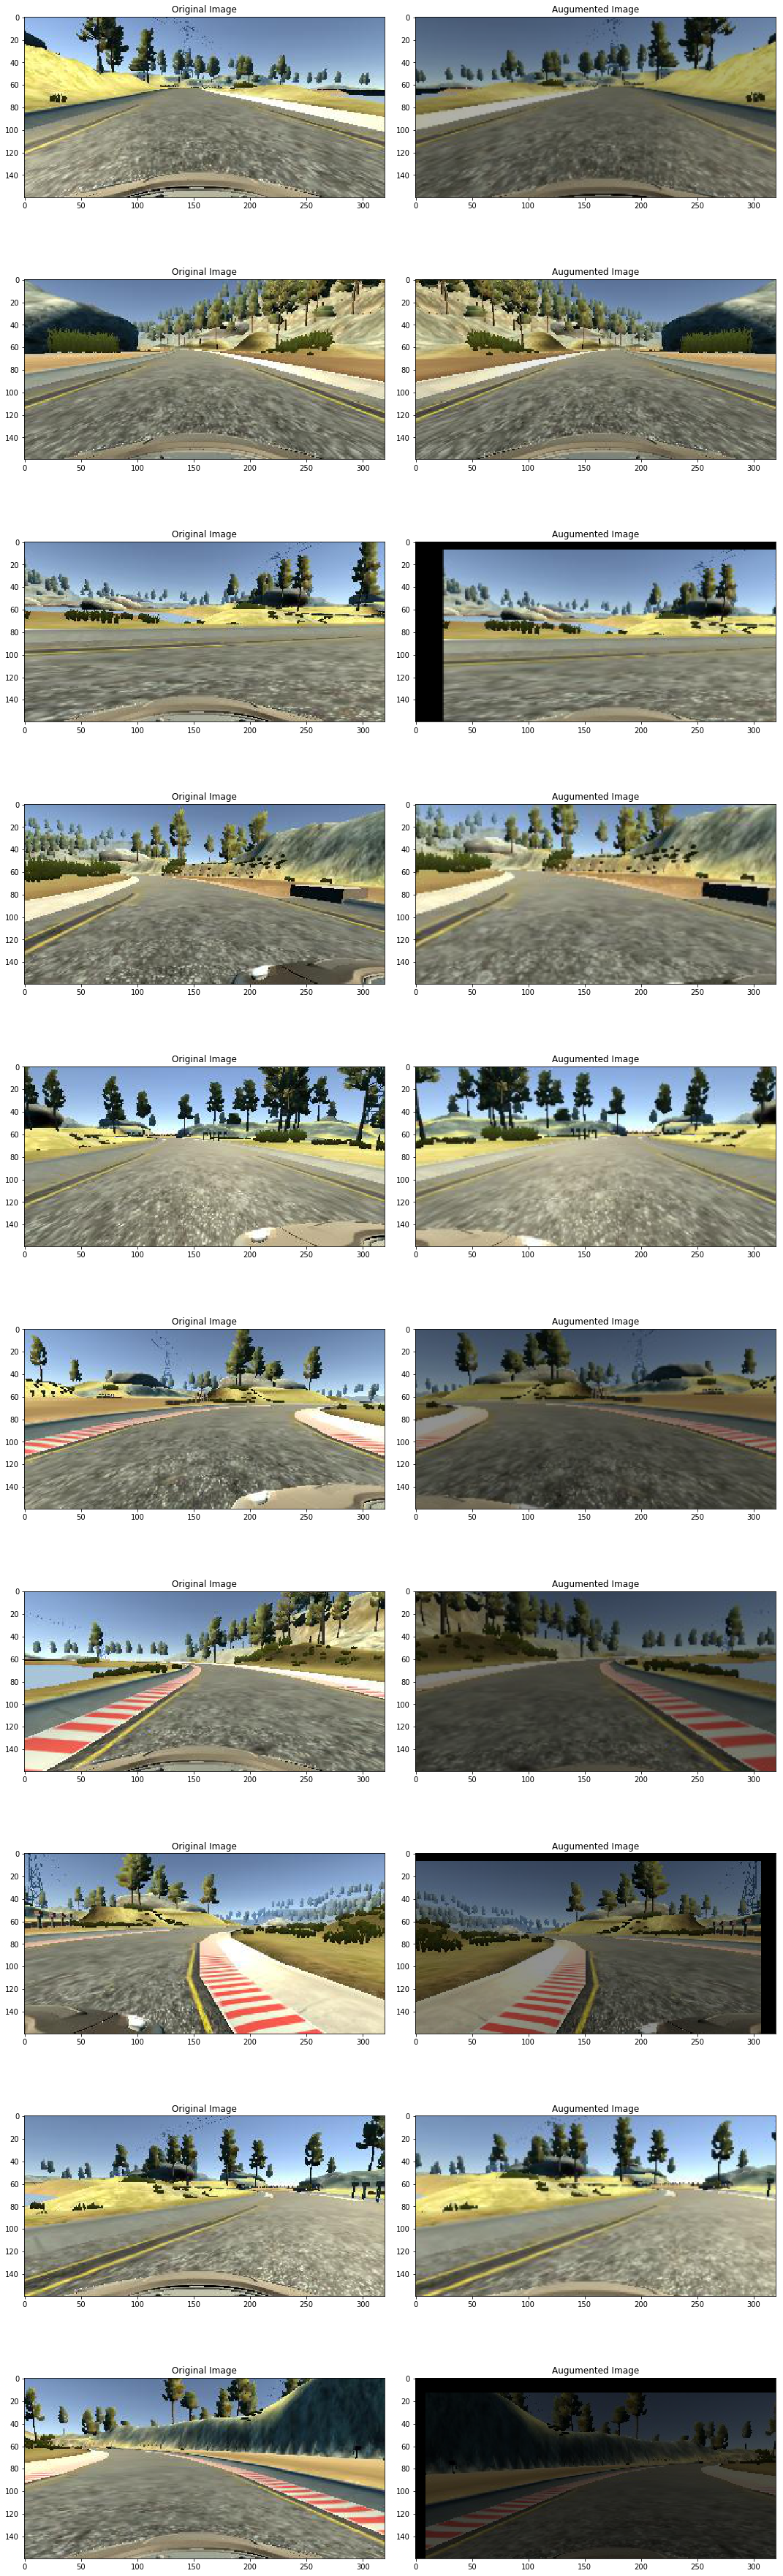

In [0]:
ncol = 2
nrow = 10
fig ,axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0 , len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augumented Image')
  

In [0]:
#Preprocessing Images
def img_preprocess(img):
  img = img[60:135, :, :] #crop chieu cao tu toa do 60-135 trong original image de loai bo nhung chi tiet thua
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #Y:do sang #U.....
  img = cv2.GaussianBlur(img, (3,3), 0) #gaussianblur lam muot hinh anh vaf lam giam do nhieu , lam gaim noise se tang toc do tinh toan
  img = cv2.resize(img,(200,66))
  img = img/255 #chuan hoa giup mo hinh hoi tu nhanh hon
  return img
  
  

Text(0.5, 1.0, 'Preprocessed Image')

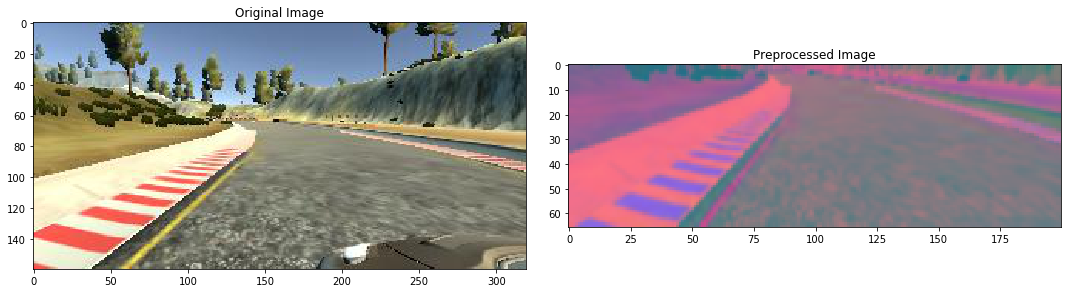

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
generated_steering_angles = []
def batch_generator(image_paths, steering_ang, batch_size, istraining):#xu ly du lieu hinh anh, dung ky thuat nay khi xu ly vs data nhieu va lon ,Có thể hiểu Generator function là một function, có khả năng tạm ngưng thực thi trước khi hàm kết thúc, và có thể tiếp tục chạy ở 1 thời điểm khác.
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):#moi 1 vong lap ta tao ra 1 augment image moi
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      generated_steering_angles.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  #Mỗi lần lệnh yield được chạy, nó sẽ sinh ra một giá trị mới Vì thế nó mới được gọi là generator
  

Text(0.5, 1.0, 'Validation Image')

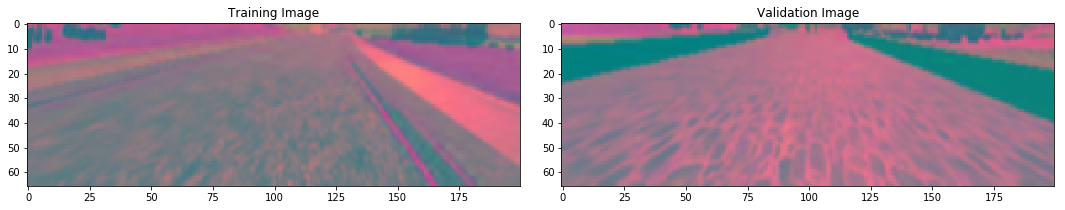

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1)) #true
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0)) #false

#chi co tap training dc agument con valid van giu nguyen du lieu cu
fig , axs = plt.subplots(1, 2, figsize=(15,10) )#1 row, 2 cols
fig.tight_layout()# dam bao du lieu dc formated va ko bi overlap

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66,200,3),activation='elu',name='Conv1')) #24 filters 5x5, stride =2
  model.add(Convolution2D(36, 5 ,5, subsample=(2,2), activation='elu',name='Conv2'))
  model.add(Convolution2D(48, 5 ,5, subsample=(2,2), activation='elu',name='Conv3')) #neu values of relu func <0 thi no se return ve 0, neu values >0 thi no se tra ve kq cua cua chinh no
  model.add(Convolution2D(64, 3 ,3, activation='elu')) #va neu values of relu func = 0 thi no se ko thay doi 
 
  
  model.add(Convolution2D(64, 3 ,3, activation='elu', name='Conv4'))
  

 # model.add(Dropout(0.5))# moi layers dc update thanh 50% inputs va bien thanh 0
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu',name='FC1'))
  #model.add(Dropout(0.5)) #0.5 là t? l? hidden unit b?n mu?n train m?i l?n
  
  model.add(Dense(50, activation='elu',name='FC2'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu',name='FC3'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer= optimizer)
  return model

In [0]:
model = nvidia_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", name="Conv1", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", name="Conv2", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", name="Conv3", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
Conv4 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu", name="Conv4")`
  if __name__ == '__main__':


In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 32, 1),
                                  steps_per_epoch=300, 
                                  epochs=3,
                                  validation_data=batch_generator(X_valid, y_valid, 32, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)
                               

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
300/300 [==============================] - 48s 159ms/step - loss: 0.0883 - val_loss: 0.0613
Epoch 2/3
300/300 [==============================] - 43s 143ms/step - loss: 0.0668 - val_loss: 0.0588
Epoch 3/3
300/300 [==============================] - 42s 142ms/step - loss: 0.0698 - val_loss: 0.0478


Text(0.5, 0, 'Epoch')

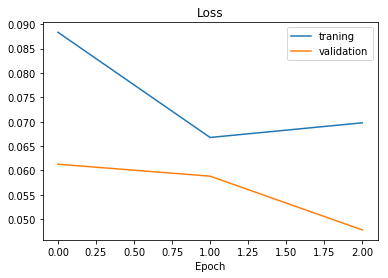

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
model.load_weights('./model.h5')

layer1 = Model(input=model.input, output=model.get_layer('Conv1').output)
layer2 = Model(input=model.input, output=model.get_layer('Conv2').output)

img_path = 'center_2016_12_01_13_38_51_331.jpg'
img = cv2.imread(preprocessed_image)
img = crop_img(img)
img = np.expand_dims(img, axis=0)
steering = model.predict(img)
visual_layer1, visual_layer2 = layer1.predict(img), layer2.predict(img)

arr_1, arr_2, layer_1, layer_2 = [], [], [], []
for i in range(32):
    arr_1.append(visual_layer1[0, :, :, i])
for i in range(64):
    arr_2.append(visual_layer2[0, :, :, i])
    
plt.figure(figsize=(8,4))
plt.plot()
plt.imshow(plt.imread(preprocessed_image))
plt.title('steering angle : '+ str(np.round(float(steering),3)))
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Co..., outputs=Tensor("Co...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("Co..., outputs=Tensor("Co...)`
  after removing the cwd from sys.path.


TypeError: ignored

In [0]:
from google.colab import files
files.download('model.h5')